In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
pd.options.display.max_columns = 500

In [2]:
import sidetable
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import precision_score, recall_score, accuracy_score as accu, f1_score, matthews_corrcoef as mcc, balanced_accuracy_score as bas
from xgboost import XGBClassifier
import time

In [4]:
import tensorflow as tf

2023-09-12 15:04:33.164573: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-12 15:04:33.267557: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-12 15:04:33.268832: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-12 15:04:34.531632: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [5]:
cancer_dataset= pd.read_csv('./cancer.csv', lineterminator='\n',sep=',')

cancer_dataset['diagnosis']=cancer_dataset['diagnosis'].map({'M':1, 'B':0}) # We set the target to be a 0/1 variable.
cancer_dataset['diagnosis']=cancer_dataset['diagnosis'].astype(int)

## Info about the data set

Features are computed from a digitized image of a fine needle aspirate (FNA) of a breast mass. They describe characteristics of the cell nuclei present in the image.
n the 3-dimensional space is that described in: [K. P. Bennett and O. L. Mangasarian: "Robust Linear Programming Discrimination of Two Linearly Inseparable Sets", Optimization Methods and Software 1, 1992, 23-34].

This database is also available through the UW CS ftp server:
ftp ftp.cs.wisc.edu
cd math-prog/cpo-dataset/machine-learn/WDBC/

Also can be found on UCI Machine Learning Repository: https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29

Attribute Information:

1) ID number
2) Diagnosis (M = malignant, B = benign)
3-32)

Ten real-valued features are computed for each cell nucleus:

a) radius (mean of distances from center to points on the perimeter)
b) texture (standard deviation of gray-scale values)
c) perimeter
d) area
e) smoothness (local variation in radius lengths)
f) compactness (perimeter^2 / area - 1.0)
g) concavity (severity of concave portions of the contour)
h) concave points (number of concave portions of the contour)
i) symmetry
j) fractal dimension ("coastline approximation" - 1)

The mean, standard error and "worst" or largest (mean of the three
largest values) of these features were computed for each image,
resulting in 30 features. For instance, field 3 is Mean Radius, field
13 is Radius SE, field 23 is Worst Radius.

All feature values are recoded with four significant digits.

Missing attribute values: none

Class distribution: 357 benign, 212 malignant

In [6]:
def info_univariado(new_df):
  df_info = pd.DataFrame(columns=['Count', 'Type' , 'Missing', 'Unique', 'Numeric'])
  for col in new_df:
    data_series = new_df[col]
    df_info.loc[col] = [data_series.count(), data_series.dtype, data_series.isnull().sum(), data_series.nunique(), pd.api.types.is_numeric_dtype(data_series)]
    df_describe = new_df.describe(include='all').T[['mean', 'std', 'min', '25%', '50%', '75%', 'max']]
    df_stats = pd.DataFrame([new_df.skew(numeric_only=True), new_df.kurtosis(numeric_only=True)], index=['skew', 'kurt']).T
  return pd.concat([df_info,pd.concat([df_describe, df_stats], axis=1)], axis=1).fillna('0')

## Split

First of all, we separate the dataset between a training set, a cross validation set and a test set. 

In [7]:
x = cancer_dataset.drop(columns=['diagnosis'])  # Features
y = cancer_dataset['diagnosis']               # target

# Get 60% of the dataset as the training set. Put the remaining 40% in temporary variables: x_ and y_.
x_train, x_, y_train, y_ = train_test_split(x, y, test_size=0.40, stratify=y, random_state=76)

# Split the 40% subset above into two: one half for cross validation and the other for the test set
x_cv, x_test, y_cv, y_test = train_test_split(x_, y_, test_size=0.50, random_state=76)

# Delete temporary variables
del x_, y_

For convenience, We also keep a dataframe, which we are going to call 'cancer', which is a training set including the target variable.

In [8]:
cancer=pd.concat([x_train, y_train], axis=1)

## EDA

In [9]:
cancer.shape

(341, 33)

In [10]:
cancer.info()

<class 'pandas.core.frame.DataFrame'>
Index: 341 entries, 5 to 463
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       341 non-null    int64  
 1   radius_mean              341 non-null    float64
 2   texture_mean             341 non-null    float64
 3   perimeter_mean           341 non-null    float64
 4   area_mean                341 non-null    float64
 5   smoothness_mean          341 non-null    float64
 6   compactness_mean         341 non-null    float64
 7   concavity_mean           341 non-null    float64
 8   concave points_mean      341 non-null    float64
 9   symmetry_mean            341 non-null    float64
 10  fractal_dimension_mean   341 non-null    float64
 11  radius_se                341 non-null    float64
 12  texture_se               341 non-null    float64
 13  perimeter_se             341 non-null    float64
 14  area_se                  341 no

In [11]:
cancer.duplicated().sum()

0

In [12]:
##See if there are duplicates by REMOVING the column called id.

(cancer[cancer.duplicated(subset=cancer.columns.difference(['Id']), keep=False)].sum().sum())/(cancer.shape[1])
#Divide by the number of columns to find out how many duplicate rows there are.

0.0

In [13]:
cancer.describe().T

,count,mean,std,min,25%,50%,75%,max
id,341.0,3.548336e+07,1.368946e+08,8670.000000,871642.000000,908916.000000,8.912049e+06,9.113205e+08
radius_mean,341.0,1.410830e+01,3.560710e+00,7.729000,11.710000,13.270000,1.578000e+01,2.811000e+01
texture_mean,341.0,1.933686e+01,4.505594e+00,10.380000,16.070000,18.870000,2.184000e+01,3.928000e+01
perimeter_mean,341.0,9.181842e+01,2.453447e+01,47.980000,75.030000,85.480000,1.058000e+02,1.885000e+02
area_mean,341.0,6.540041e+02,3.561421e+02,178.800000,420.300000,541.600000,7.826000e+02,2.499000e+03
smoothness_mean,341.0,9.573390e-02,1.400347e-02,0.064290,0.085180,0.094620,1.042000e-01,1.634000e-01
compactness_mean,341.0,1.032218e-01,5.341161e-02,0.023440,0.064920,0.090090,1.298000e-01,3.454000e-01
concavity_mean,341.0,8.863568e-02,8.099365e-02,0.000000,0.029580,0.059400,1.226000e-01,4.268000e-01
concave points_mean,341.0,4.773480e-02,3.825307e-02,0.000000,0.019690,0.032500,6.987000e-02,2.012000e-01
symmetry_mean,341.0,1.812305e-01,2.705045e-02,0.106000,0.162700,0.180000,1.957000e-01,2.906000e-01


In [14]:
cancer.sample(10)

,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,\r,diagnosis
50,857343,11.760,21.60,74.72,427.9,0.08637,0.04966,0.01657,0.01115,0.1495,0.05888,0.4062,1.2100,2.635,28.47,0.005857,0.009758,0.01168,0.007445,0.02406,0.001769,12.980,25.72,82.98,516.5,0.10850,0.08615,0.05523,0.03715,0.2433,0.06563,NaN,0
369,9012000,22.010,21.90,147.20,1482.0,0.10630,0.19540,0.24480,0.15010,0.1824,0.06140,1.0080,0.6999,7.561,130.20,0.003978,0.028210,0.03576,0.014710,0.01518,0.003796,27.660,25.80,195.00,2227.0,0.12940,0.38850,0.47560,0.24320,0.2741,0.08574,NaN,1
71,859711,8.888,14.64,58.79,244.0,0.09783,0.15310,0.08606,0.02872,0.1902,0.08980,0.5262,0.8522,3.168,25.44,0.017210,0.093680,0.05671,0.017660,0.02541,0.021930,9.733,15.67,62.56,284.4,0.12070,0.24360,0.14340,0.04786,0.2254,0.10840,NaN,0
501,91504,13.820,24.49,92.33,595.9,0.11620,0.16810,0.13570,0.06759,0.2275,0.07237,0.4751,1.5280,2.974,39.05,0.009680,0.038560,0.03476,0.016160,0.02434,0.006995,16.010,32.94,106.00,788.0,0.17940,0.39660,0.33810,0.15210,0.3651,0.11830,NaN,1
204,87930,12.470,18.60,81.09,481.9,0.09965,0.10580,0.08005,0.03821,0.1925,0.06373,0.3961,1.0440,2.497,30.29,0.006953,0.019110,0.02701,0.010370,0.01782,0.003586,14.970,24.64,96.05,677.9,0.14260,0.23780,0.26710,0.10150,0.3014,0.08750,NaN,0
416,905978,9.405,21.70,59.60,271.2,0.10440,0.06159,0.02047,0.01257,0.2025,0.06601,0.4302,2.8780,2.759,25.17,0.014740,0.016740,0.01367,0.008674,0.03044,0.004590,10.850,31.24,68.73,359.4,0.15260,0.11930,0.06141,0.03770,0.2872,0.08304,NaN,0
130,866714,12.190,13.29,79.08,455.8,0.10660,0.09509,0.02855,0.02882,0.1880,0.06471,0.2005,0.8163,1.973,15.24,0.006773,0.024560,0.01018,0.008094,0.02662,0.004143,13.340,17.81,91.38,545.2,0.14270,0.25850,0.09915,0.08187,0.3469,0.09241,NaN,0
284,8912284,12.890,15.70,84.08,516.6,0.07818,0.09580,0.11150,0.03390,0.1432,0.05935,0.2913,1.3890,2.347,23.29,0.006418,0.039610,0.07927,0.017740,0.01878,0.003696,13.900,19.69,92.12,595.6,0.09926,0.23170,0.33440,0.10170,0.1999,0.07127,NaN,0
121,86517,18.660,17.12,121.40,1077.0,0.10540,0.11000,0.14570,0.08665,0.1966,0.06213,0.7128,1.5810,4.895,90.47,0.008102,0.021010,0.03342,0.016010,0.02045,0.004570,22.250,24.90,145.40,1549.0,0.15030,0.22910,0.32720,0.16740,0.2894,0.08456,NaN,1
444,9110127,18.030,16.85,117.50,990.0,0.08947,0.12320,0.10900,0.06254,0.1720,0.05780,0.2986,0.5906,1.921,35.77,0.004117,0.015600,0.02975,0.009753,0.01295,0.002436,20.380,22.02,133.30,1292.0,0.12630,0.26660,0.42900,0.15350,0.2842,0.08225,NaN,1


In [15]:
cancer.describe()

,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,\r,diagnosis
count,3.410000e+02,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.00000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,0.0,341.000000
mean,3.548336e+07,14.108299,19.336862,91.818416,654.004106,0.095734,0.103222,0.088636,0.047735,0.18123,0.062544,0.403384,1.202780,2.849161,40.037956,0.007084,0.025388,0.032851,0.011637,0.020798,0.003739,16.251079,25.717243,107.175513,880.585337,0.132345,0.254388,0.277136,0.113614,0.291694,0.083687,NaN,0.372434
std,1.368946e+08,3.560710,4.505594,24.534467,356.142106,0.014003,0.053412,0.080994,0.038253,0.02705,0.007146,0.275739,0.554241,2.012244,44.267597,0.003141,0.018220,0.034203,0.006239,0.008462,0.002696,4.875121,6.383913,33.924566,573.090816,0.022987,0.157996,0.212917,0.065055,0.060563,0.018267,NaN,0.484164
min,8.670000e+03,7.729000,10.380000,47.980000,178.800000,0.064290,0.023440,0.000000,0.000000,0.10600,0.050240,0.116600,0.362100,0.771400,7.254000,0.001713,0.003710,0.000000,0.000000,0.009539,0.000895,8.964000,12.490000,57.170000,242.200000,0.071170,0.027290,0.000000,0.000000,0.156600,0.055210,NaN,0.000000
25%,8.716420e+05,11.710000,16.070000,75.030000,420.300000,0.085180,0.064920,0.029580,0.019690,0.16270,0.057800,0.233800,0.842900,1.614000,18.150000,0.005251,0.013150,0.015140,0.007584,0.014990,0.002256,13.010000,21.030000,83.690000,512.500000,0.116600,0.150700,0.114400,0.064930,0.251400,0.071980,NaN,0.000000
50%,9.089160e+05,13.270000,18.870000,85.480000,541.600000,0.094620,0.090090,0.059400,0.032500,0.18000,0.061290,0.314100,1.075000,2.257000,24.190000,0.006418,0.020450,0.025890,0.010520,0.018970,0.003048,14.800000,25.230000,97.170000,670.600000,0.131300,0.216700,0.243900,0.097830,0.284800,0.079530,NaN,0.000000
75%,8.912049e+06,15.780000,21.840000,105.800000,782.600000,0.104200,0.129800,0.122600,0.069870,0.19570,0.065560,0.478900,1.473000,3.301000,45.190000,0.008074,0.032070,0.040400,0.014610,0.024010,0.004406,18.550000,30.120000,124.300000,1044.000000,0.146300,0.334500,0.379400,0.159500,0.317900,0.091360,NaN,1.000000
max,9.113205e+08,28.110000,39.280000,188.500000,2499.000000,0.163400,0.345400,0.426800,0.201200,0.29060,0.095750,2.873000,4.885000,21.980000,525.600000,0.031130,0.135400,0.396000,0.052790,0.078950,0.029840,33.120000,49.540000,220.800000,3432.000000,0.218400,1.058000,1.252000,0.286700,0.555800,0.207500,NaN,1.000000


In [16]:
info_univariado(cancer)

,Count,Type,Missing,Unique,Numeric,mean,std,min,25%,50%,75%,max,skew,kurt
id,341,int64,0,341,True,35483356.281525,136894569.018829,8670.0,871642.0,908916.0,8912049.0,911320501.0,5.882856,34.460598
radius_mean,341,float64,0,296,True,14.108299,3.56071,7.729,11.71,13.27,15.78,28.11,1.001013,0.971699
texture_mean,341,float64,0,306,True,19.336862,4.505594,10.38,16.07,18.87,21.84,39.28,0.732102,1.100191
perimeter_mean,341,float64,0,318,True,91.818416,24.534467,47.98,75.03,85.48,105.8,188.5,1.043305,1.05834
area_mean,341,float64,0,325,True,654.004106,356.142106,178.8,420.3,541.6,782.6,2499.0,1.666217,3.57115
smoothness_mean,341,float64,0,300,True,0.095734,0.014003,0.06429,0.08518,0.09462,0.1042,0.1634,0.614502,1.253137
compactness_mean,341,float64,0,331,True,0.103222,0.053412,0.02344,0.06492,0.09009,0.1298,0.3454,1.348806,2.273869
concavity_mean,341,float64,0,324,True,0.088636,0.080994,0.0,0.02958,0.0594,0.1226,0.4268,1.510665,2.364742
concave points_mean,341,float64,0,326,True,0.047735,0.038253,0.0,0.01969,0.0325,0.06987,0.2012,1.262857,1.454098
symmetry_mean,341,float64,0,290,True,0.18123,0.02705,0.106,0.1627,0.18,0.1957,0.2906,0.64058,1.10816


In [17]:
cancer['diagnosis'].value_counts()

diagnosis
0    214
1    127
Name: count, dtype: int64

## Insights

* There are 10 characteristics that have 3 columns each: average value, worst value and standard deviation. They are all numerical and continuous variables.
* The target variable is diagnosis. It's not very imbalanced. There are 357 benign and 212 malignant.
* The id column should be thrown away, it is not useful information for predicting.
* The last column is named \r and has no data.

[Text(0.5, 0, 'Radio máximo de las células'), Text(0, 0.5, 'Percent')]

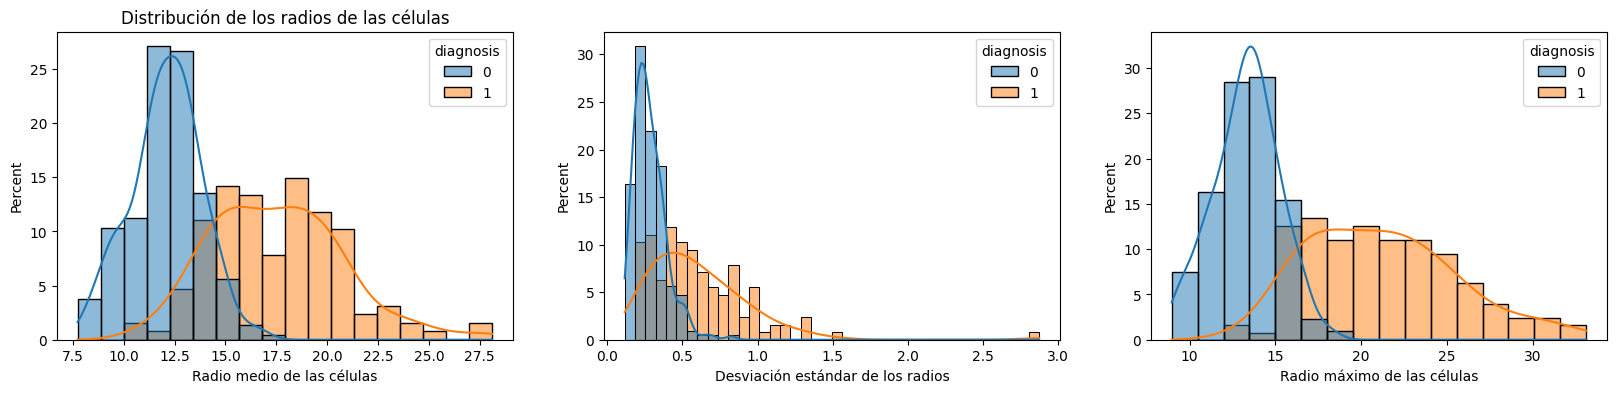

In [18]:
fig, ax = plt.subplots(nrows=1, ncols=3,figsize=(20,4))
sns.histplot(data=cancer, x='radius_mean', hue=cancer.diagnosis, kde=True, ax=ax[0],stat='percent', common_norm=False)
ax[0].set(xlabel='Radio medio de las células', ylabel='Percent')
ax[0].set_title("Distribución de los radios de las células")

sns.histplot(data=cancer, x='radius_se', hue=cancer.diagnosis, kde=True, ax=ax[1],stat='percent', common_norm=False)
ax[1].set(xlabel='Desviación estándar de los radios', ylabel='Percent')

sns.histplot(data=cancer, x='radius_worst', hue=cancer.diagnosis, kde=True, ax=ax[2],stat='percent', common_norm=False)
ax[2].set(xlabel='Radio máximo de las células', ylabel='Percent')

There is a significant difference between the distributions of benign and malignant tumors. Malignant tumors tend to be more than 5 cm larger, and the spread of their sizes is somewhat higher.

Let's see the rest of the features.

[Text(0.5, 0, 'Gris máximo de las células'), Text(0, 0.5, 'Percent')]

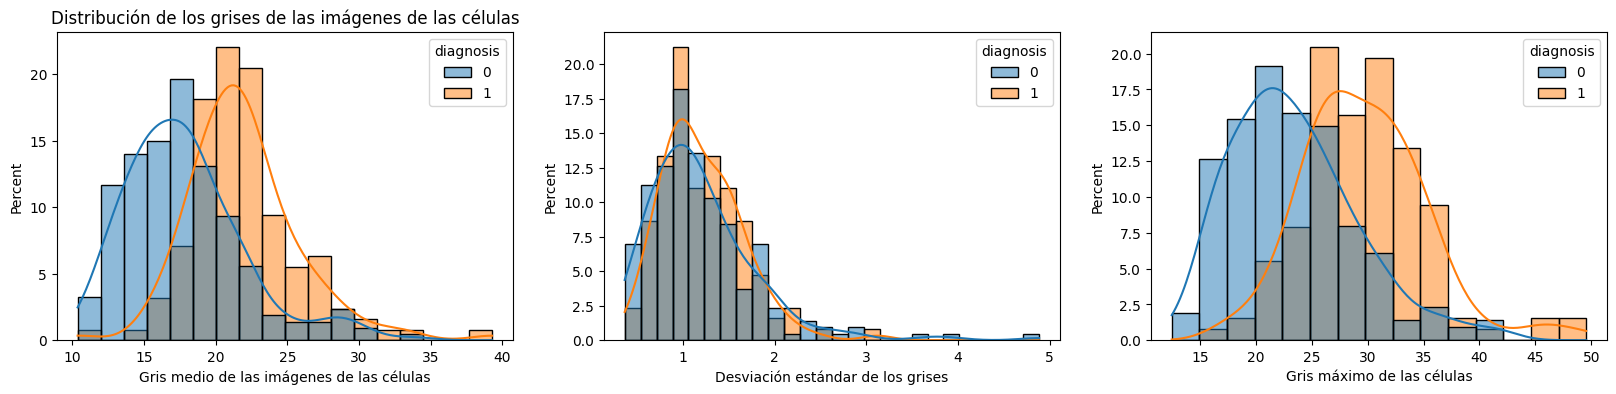

In [19]:
fig, ax = plt.subplots(nrows=1, ncols=3,figsize=(20,4))
sns.histplot(data=cancer, x='texture_mean', hue=cancer.diagnosis, kde=True, ax=ax[0],stat='percent', common_norm=False)
ax[0].set(xlabel='Gris medio de las imágenes de las células', ylabel='Percent')
ax[0].set_title("Distribución de los grises de las imágenes de las células")

sns.histplot(data=cancer, x='texture_se', hue=cancer.diagnosis, kde=True, ax=ax[1],stat='percent', common_norm=False)
ax[1].set(xlabel='Desviación estándar de los grises', ylabel='Percent')

sns.histplot(data=cancer, x='texture_worst', hue=cancer.diagnosis, kde=True, ax=ax[2],stat='percent', common_norm=False)
ax[2].set(xlabel='Gris máximo de las células', ylabel='Percent')

[Text(0.5, 0, 'Perímetro máximo de las células'), Text(0, 0.5, 'Percent')]

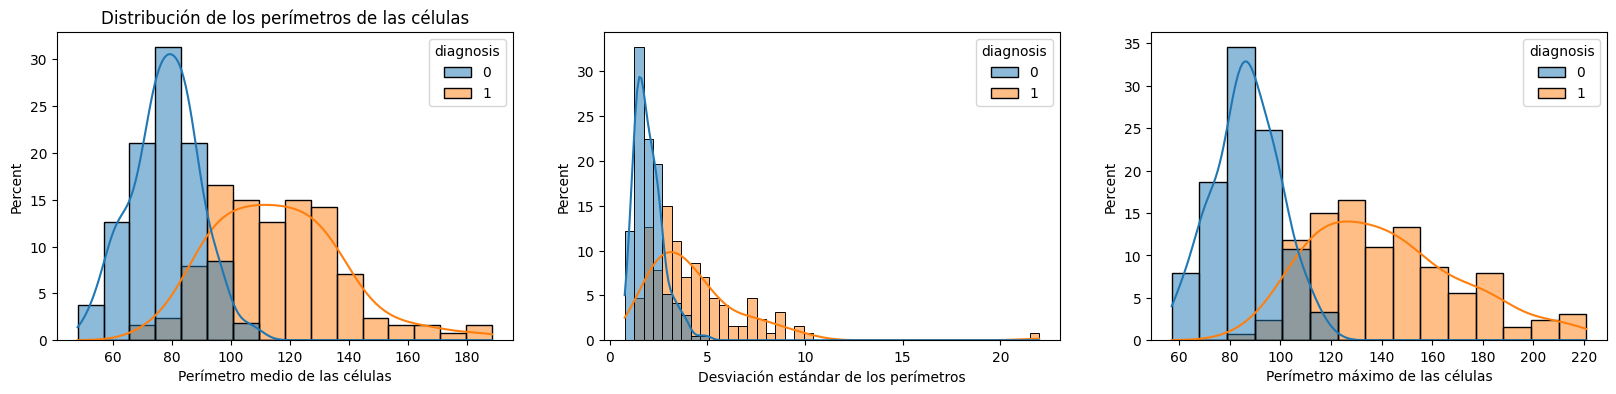

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=3,figsize=(20,4))
sns.histplot(data=cancer, x='perimeter_mean', hue=cancer.diagnosis, kde=True, ax=ax[0],stat='percent', common_norm=False)
ax[0].set(xlabel='Perímetro medio de las células', ylabel='Percent')
ax[0].set_title("Distribución de los perímetros de las células")

sns.histplot(data=cancer, x='perimeter_se', hue=cancer.diagnosis, kde=True, ax=ax[1],stat='percent', common_norm=False)
ax[1].set(xlabel='Desviación estándar de los perímetros', ylabel='Percent')

sns.histplot(data=cancer, x='perimeter_worst', hue=cancer.diagnosis, kde=True, ax=ax[2],stat='percent', common_norm=False)
ax[2].set(xlabel='Perímetro máximo de las células', ylabel='Percent')

[Text(0.5, 0, 'Área máxima de las células'), Text(0, 0.5, 'Percent')]

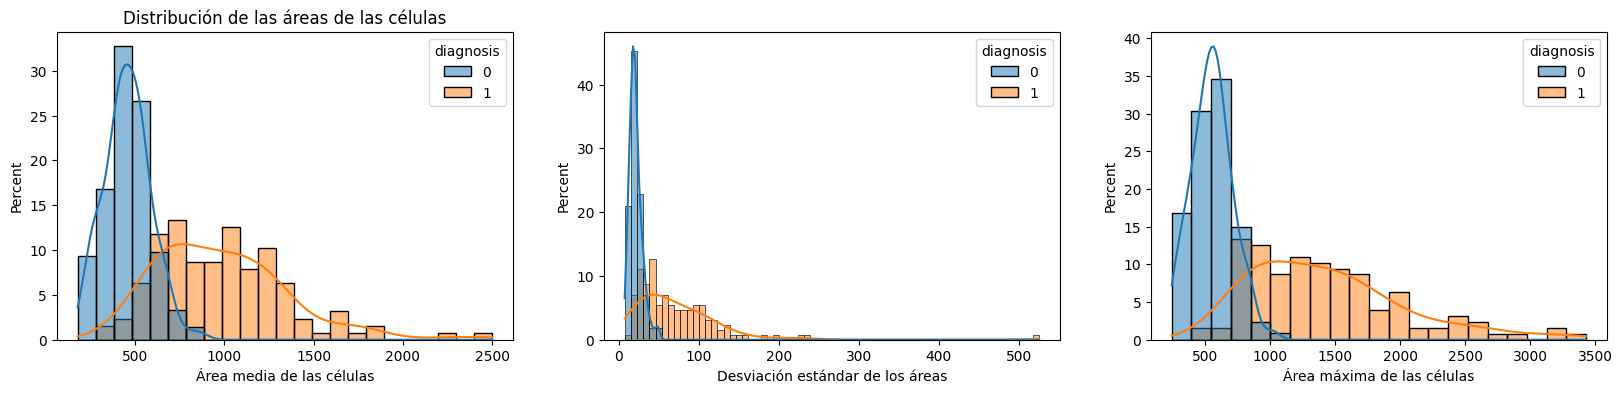

In [21]:
fig, ax = plt.subplots(nrows=1, ncols=3,figsize=(20,4))
sns.histplot(data=cancer, x='area_mean', hue=cancer.diagnosis, kde=True, ax=ax[0],stat='percent', common_norm=False)
ax[0].set(xlabel='Área media de las células', ylabel='Percent')
ax[0].set_title("Distribución de las áreas de las células")

sns.histplot(data=cancer, x='area_se', hue=cancer.diagnosis, kde=True, ax=ax[1],stat='percent', common_norm=False)
ax[1].set(xlabel='Desviación estándar de los áreas', ylabel='Percent')

sns.histplot(data=cancer, x='area_worst', hue=cancer.diagnosis, kde=True, ax=ax[2],stat='percent', common_norm=False)
ax[2].set(xlabel='Área máxima de las células', ylabel='Percent')

[Text(0.5, 0, 'Smoothness máximo'), Text(0, 0.5, 'Percent')]

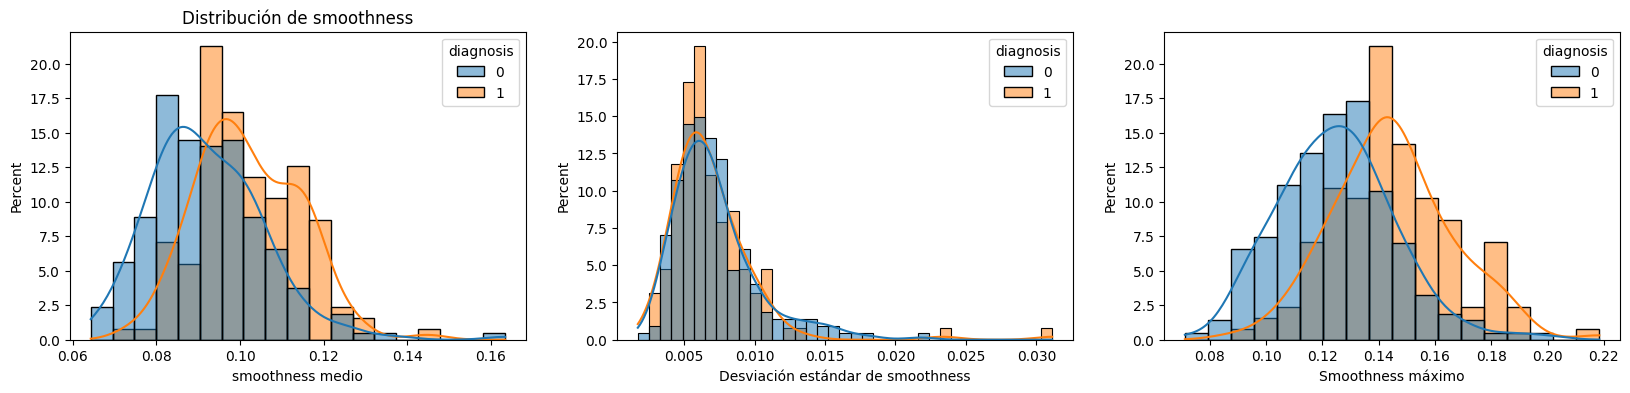

In [22]:
fig, ax = plt.subplots(nrows=1, ncols=3,figsize=(20,4))
sns.histplot(data=cancer, x='smoothness_mean', hue=cancer.diagnosis, kde=True, ax=ax[0],stat='percent', common_norm=False)
ax[0].set(xlabel='smoothness medio', ylabel='Percent')
ax[0].set_title("Distribución de smoothness")

sns.histplot(data=cancer, x='smoothness_se', hue=cancer.diagnosis, kde=True, ax=ax[1],stat='percent', common_norm=False)
ax[1].set(xlabel='Desviación estándar de smoothness', ylabel='Percent')

sns.histplot(data=cancer, x='smoothness_worst', hue=cancer.diagnosis, kde=True, ax=ax[2],stat='percent', common_norm=False)
ax[2].set(xlabel='Smoothness máximo', ylabel='Percent')

[Text(0.5, 0, 'Compactness máximo'), Text(0, 0.5, 'Percent')]

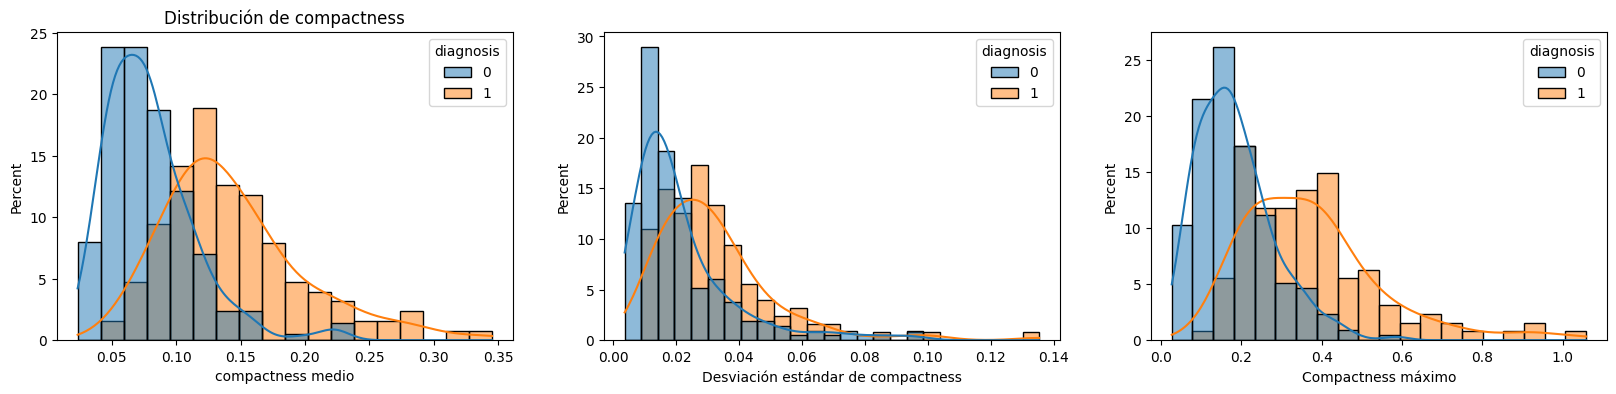

In [23]:
fig, ax = plt.subplots(nrows=1, ncols=3,figsize=(20,4))
sns.histplot(data=cancer, x='compactness_mean', hue=cancer.diagnosis, kde=True, ax=ax[0],stat='percent', common_norm=False)
ax[0].set(xlabel='compactness medio', ylabel='Percent')
ax[0].set_title('Distribución de compactness')

sns.histplot(data=cancer, x='compactness_se', hue=cancer.diagnosis, kde=True, ax=ax[1],stat='percent', common_norm=False)
ax[1].set(xlabel='Desviación estándar de compactness', ylabel='Percent')

sns.histplot(data=cancer, x='compactness_worst', hue=cancer.diagnosis, kde=True, ax=ax[2],stat='percent', common_norm=False)
ax[2].set(xlabel='Compactness máximo', ylabel='Percent')

[Text(0.5, 0, 'Concavity máximo'), Text(0, 0.5, 'Percent')]

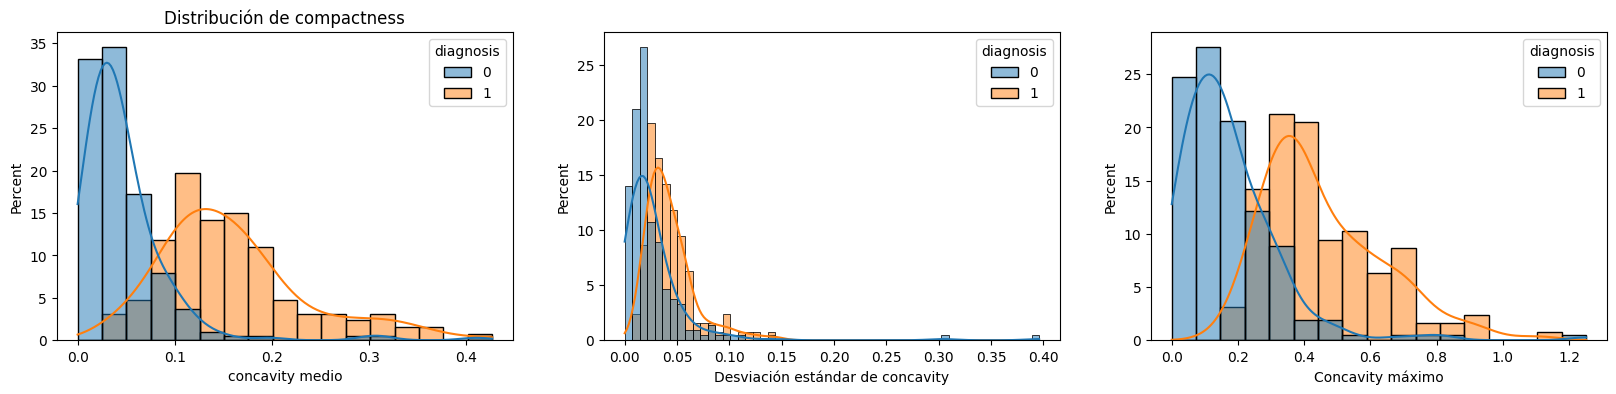

In [24]:
fig, ax = plt.subplots(nrows=1, ncols=3,figsize=(20,4))
sns.histplot(data=cancer, x='concavity_mean', hue=cancer.diagnosis, kde=True, ax=ax[0],stat='percent', common_norm=False)
ax[0].set(xlabel='concavity medio', ylabel='Percent')
ax[0].set_title('Distribución de compactness')

sns.histplot(data=cancer, x='concavity_se', hue=cancer.diagnosis, kde=True, ax=ax[1],stat='percent', common_norm=False)
ax[1].set(xlabel='Desviación estándar de concavity', ylabel='Percent')

sns.histplot(data=cancer, x='concavity_worst', hue=cancer.diagnosis, kde=True, ax=ax[2],stat='percent', common_norm=False)
ax[2].set(xlabel='Concavity máximo', ylabel='Percent')

[Text(0.5, 0, 'Concave points máximo'), Text(0, 0.5, 'Percent')]

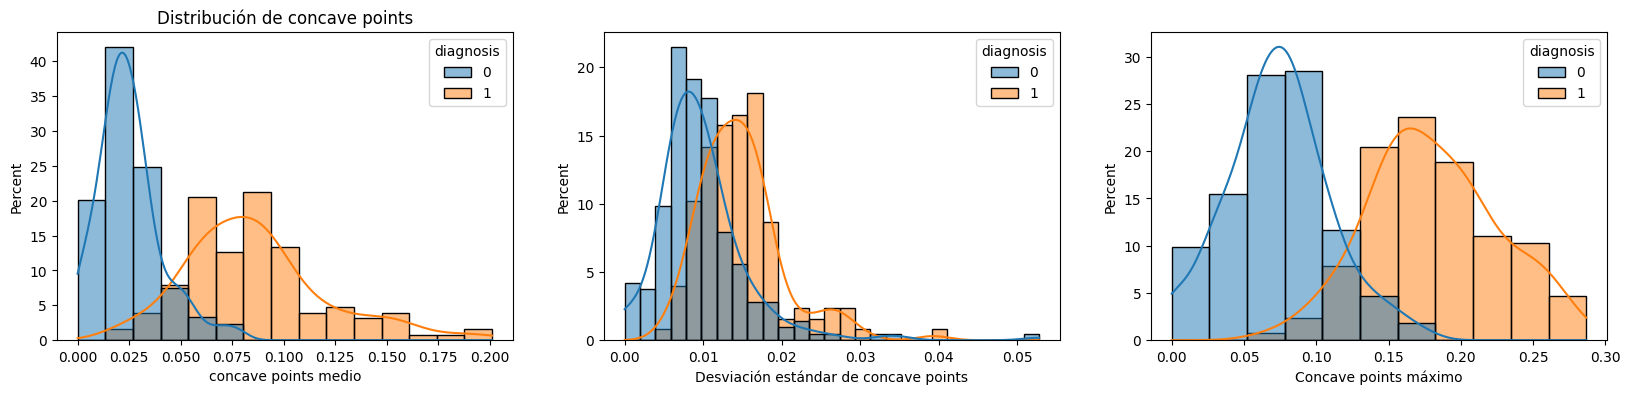

In [25]:
fig, ax = plt.subplots(nrows=1, ncols=3,figsize=(20,4))
sns.histplot(data=cancer, x='concave points_mean', hue=cancer.diagnosis, kde=True, ax=ax[0],stat='percent', common_norm=False)
ax[0].set(xlabel='concave points medio', ylabel='Percent')
ax[0].set_title('Distribución de concave points')

sns.histplot(data=cancer, x='concave points_se', hue=cancer.diagnosis, kde=True, ax=ax[1],stat='percent', common_norm=False)
ax[1].set(xlabel='Desviación estándar de concave points', ylabel='Percent')

sns.histplot(data=cancer, x='concave points_worst', hue=cancer.diagnosis, kde=True, ax=ax[2],stat='percent', common_norm=False)
ax[2].set(xlabel='Concave points máximo', ylabel='Percent')

[Text(0.5, 0, 'symmetry máximo'), Text(0, 0.5, 'Percent')]

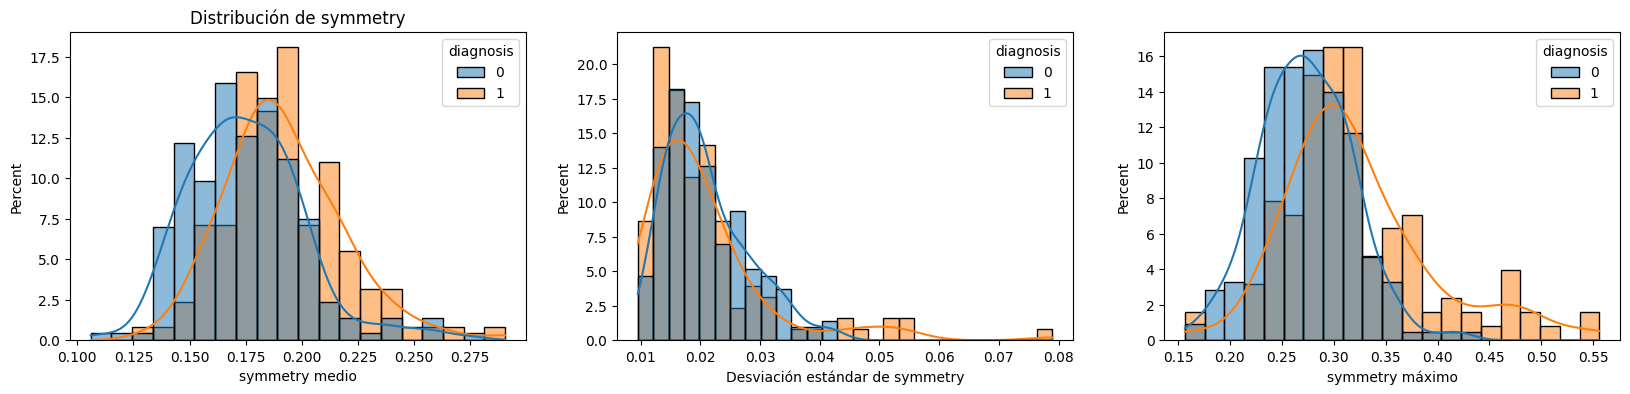

In [26]:
fig, ax = plt.subplots(nrows=1, ncols=3,figsize=(20,4))
sns.histplot(data=cancer, x='symmetry_mean', hue=cancer.diagnosis, kde=True, ax=ax[0],stat='percent', common_norm=False)
ax[0].set(xlabel='symmetry medio', ylabel='Percent')
ax[0].set_title('Distribución de symmetry')

sns.histplot(data=cancer, x='symmetry_se', hue=cancer.diagnosis, kde=True, ax=ax[1],stat='percent', common_norm=False)
ax[1].set(xlabel='Desviación estándar de symmetry', ylabel='Percent')

sns.histplot(data=cancer, x='symmetry_worst', hue=cancer.diagnosis, kde=True, ax=ax[2],stat='percent', common_norm=False)
ax[2].set(xlabel='symmetry máximo', ylabel='Percent')

[Text(0.5, 0, 'fractal_dimension máximo'), Text(0, 0.5, 'Percent')]

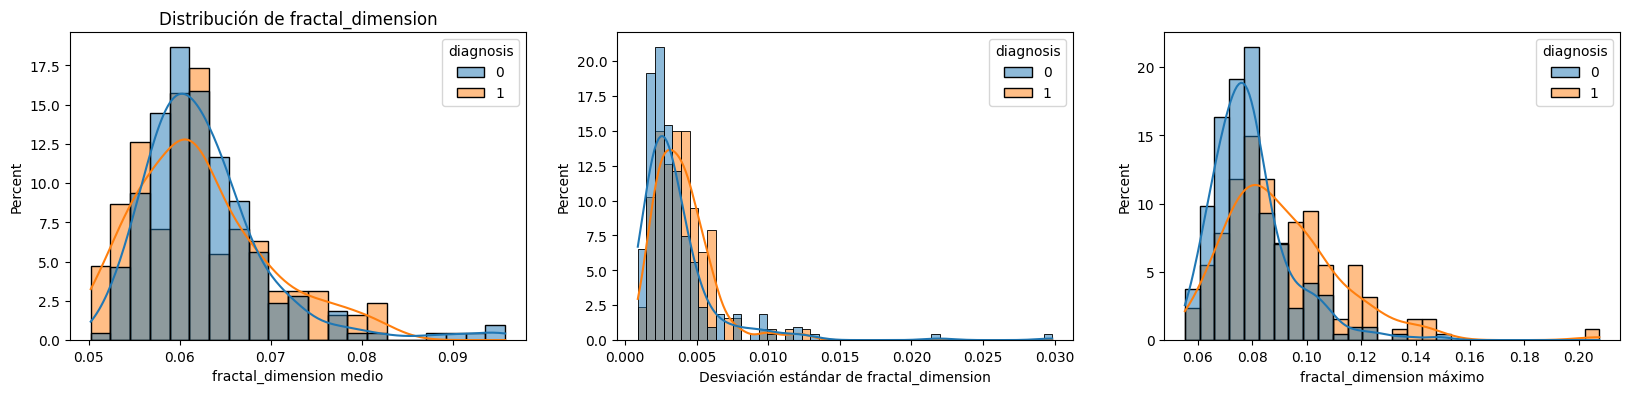

In [27]:
fig, ax = plt.subplots(nrows=1, ncols=3,figsize=(20,4))
sns.histplot(data=cancer, x='fractal_dimension_mean', hue=cancer.diagnosis, kde=True, ax=ax[0],stat='percent', common_norm=False)
ax[0].set(xlabel='fractal_dimension medio', ylabel='Percent')
ax[0].set_title('Distribución de fractal_dimension')

sns.histplot(data=cancer, x='fractal_dimension_se', hue=cancer.diagnosis, kde=True, ax=ax[1],stat='percent', common_norm=False)
ax[1].set(xlabel='Desviación estándar de fractal_dimension', ylabel='Percent')

sns.histplot(data=cancer, x='fractal_dimension_worst', hue=cancer.diagnosis, kde=True, ax=ax[2],stat='percent', common_norm=False)
ax[2].set(xlabel='fractal_dimension máximo', ylabel='Percent')

Vemos que smoothness, symmmetry y fractal_dimension son características donde no se diferencias tanto las células benignas y las malignas.

## Correlation between variables

Let's see the correlation between the variables. We are going to group the variables that correspond to the same feature adjacently to make it clearer. We also convert the target column to zeros and ones and throw away the id column as it does not contribute.

In [28]:
cancer.drop(columns=['id', '\r'], inplace=True)

In [29]:
cancer_sorted = cancer.sort_index(axis=1)


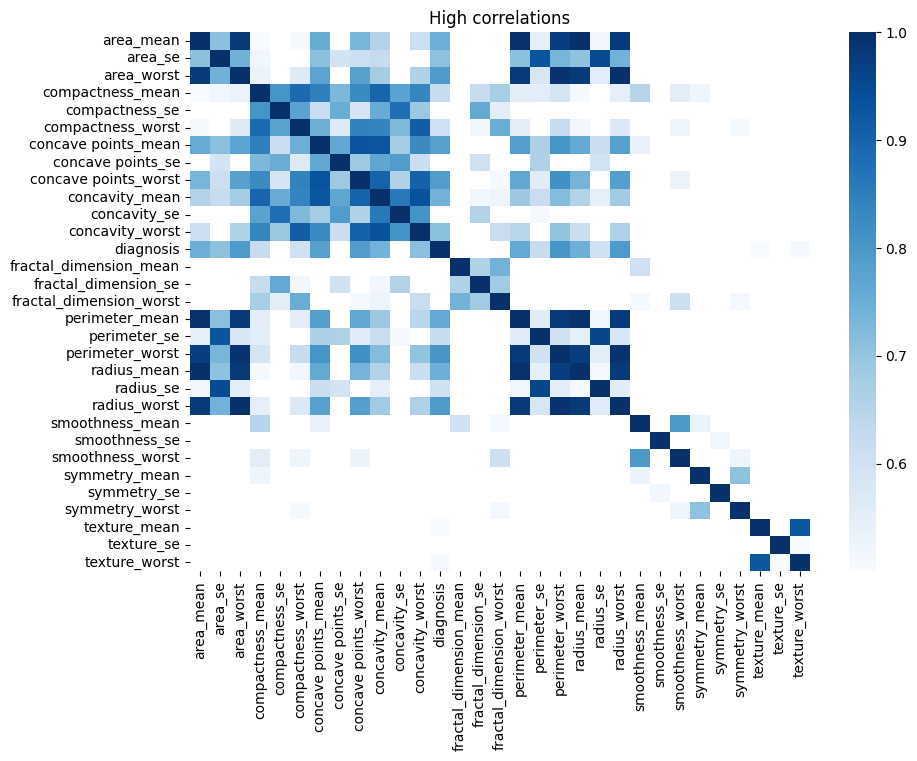

In [30]:
matrix_correlation = cancer_sorted.corr(method='spearman', numeric_only = True) 
high_corr = matrix_correlation[np.abs(matrix_correlation)>=.5] 
plt.figure(figsize=(10,7))
sns.heatmap(high_corr, cmap="Blues")
plt.title('High correlations');

We see that the mean and worst columns of each feature are always correlated. Between the mean and se columns, sometimes they present high correlation and sometimes not.

We also see high correlation between the area, perimeter and radius columns, and between the compactness, concave_points and concavity columns. Between these two groups we also see correlation.

To visualize these relationships we can also make scatterplots between the main features in pairs:

/home/tristamshandy/Python/ml/env/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1200x1200 with 0 Axes>

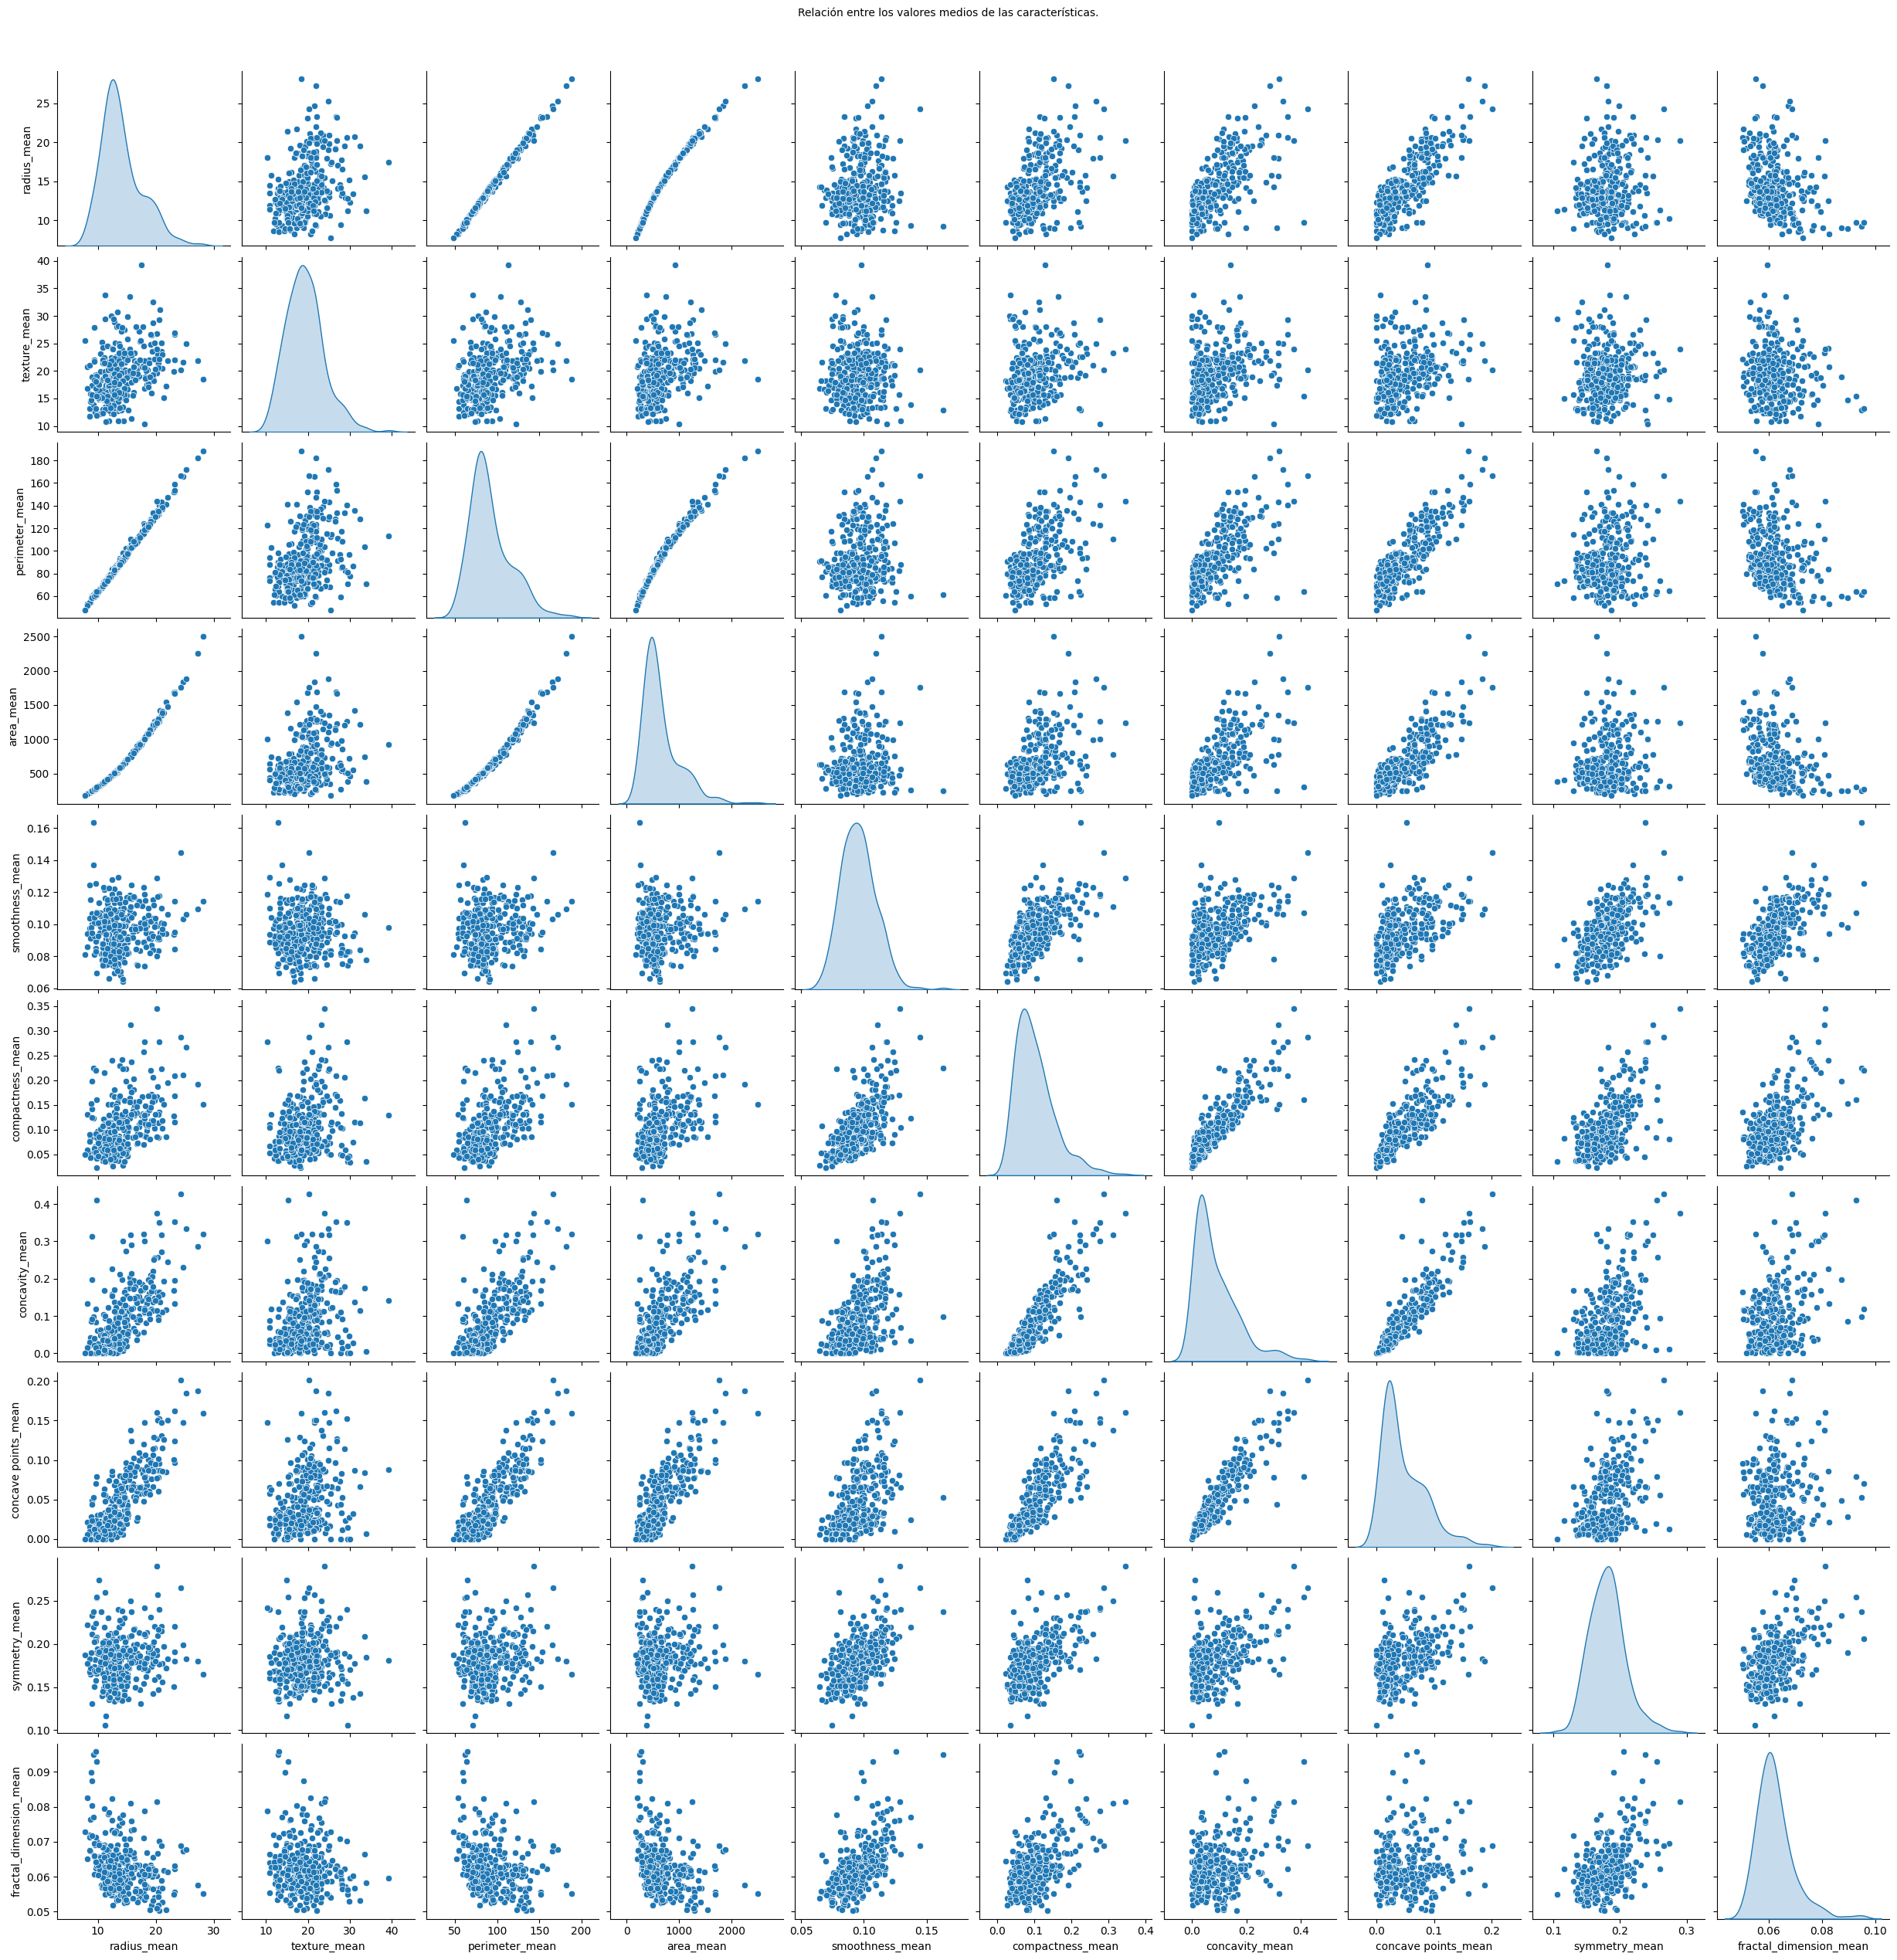

In [31]:
plt.figure(figsize=(12, 12));

g = sns.pairplot(cancer[['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean','smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean']], diag_kind='kde');
g.fig.suptitle("Relación entre los valores medios de las características.", fontsize=10, y=1.02);

In the scatter plots the correlations between radius, perimeter and area are clearly seen. Also weaker correlations between radii, concave_points and compactness.

To know which columns to keep among the correlated ones, we see the correlation with the target column.


In [32]:
abs(matrix_correlation['diagnosis']).sort_values(ascending=False)

diagnosis                  1.000000
perimeter_worst            0.803232
area_worst                 0.793557
radius_worst               0.793436
concave points_worst       0.789498
concave points_mean        0.780192
perimeter_mean             0.761083
area_mean                  0.748697
radius_mean                0.748145
concavity_mean             0.741987
concavity_worst            0.712655
area_se                    0.707165
perimeter_se               0.620864
compactness_mean           0.619539
compactness_worst          0.602439
radius_se                  0.598003
texture_worst              0.506618
texture_mean               0.500211
concave points_se          0.495377
concavity_se               0.486657
smoothness_worst           0.429748
compactness_se             0.386611
symmetry_worst             0.365198
smoothness_mean            0.363381
symmetry_mean              0.308662
fractal_dimension_worst    0.297137
fractal_dimension_se       0.209450
symmetry_se                0

We then see that among the variables correlated with each other: area, perimeter, radius, 'compactness', 'concave_points' and 'concavity'; the most correlated with the objective is 'perimeter_worst'. So we left that one.

On the other hand, 'perimeter_se', 'radius_se' and 'area_se' have high correlation with 'perimeter_worst', while 'concave points_se', 'compactness_se' have a lower correlation:

In [33]:
abs(matrix_correlation['perimeter_worst']).sort_values(ascending=False)

perimeter_worst            1.000000
radius_worst               0.993827
area_worst                 0.992912
perimeter_mean             0.979822
area_mean                  0.973692
radius_mean                0.973586
concave points_worst       0.813860
concave points_mean        0.806118
diagnosis                  0.803232
area_se                    0.735062
concavity_mean             0.719206
concavity_worst            0.701941
compactness_worst          0.620563
perimeter_se               0.601447
compactness_mean           0.591010
radius_se                  0.549883
concave points_se          0.452903
concavity_se               0.444028
texture_worst              0.434451
texture_mean               0.425230
compactness_se             0.362099
smoothness_se              0.319900
symmetry_se                0.270513
fractal_dimension_mean     0.255903
symmetry_worst             0.247644
smoothness_worst           0.234152
smoothness_mean            0.185718
fractal_dimension_worst    0

So of the 18 variables 'area_mean', 'area_se', 'area_worst', 'compactness_mean', 'compactness_se', 'compactness_worst', 'concave points_mean', 'concave points_se', 'concave points_worst', 'concavity_mean', 'concavity_se', 'concavity_worst', 'perimeter_mean', 'perimeter_se', 'perimeter_worst', 'radius_mean', 'radius_se', 'radius_worst' we just leave:

In [34]:
features_1=['perimeter_worst', 'concave points_se', 'compactness_se']

The three columns of fractal_dimension are highly correlated with each other, and are also highly correlated with 'smoothness_mean' and 'smoothness_worst'. So seeing the relationship with the target variable, of these 5 columns we only leave 'smoothness_worst'.

The rest of the deviation columns have no obvious correlation with any of the others, so the rest of the columns we leave are:

In [35]:
features_2=['smoothness_worst', 'symmetry_worst', 'texture_worst', 'smoothness_se', 'symmetry_se', 'texture_se']

In [36]:
features=features_1+features_2

## Preprocessing

In [37]:
scaler = StandardScaler() 
scaler.fit(x_train[features]) # We scale only with the data of the training set. 

StandardScaler()

In [38]:
def preproc(df, cols):
    df=df[cols]
    df_preproc = scaler.transform(df)
    df_preproc = pd.DataFrame(df_preproc, columns=df.columns, index=df.index)
    return df_preproc

In [39]:
x_train=preproc(x_train, features) #transform training data
x_cv = preproc(x_cv, features) #transform cross-validation data
x_test = preproc(x_test, features) #transform test data

## Model evaluation

We are going to calculate several metrics to see the comparison between the different models. Although the metric that we are going to consider most important and as a decision criterion is going to be the MCC metric.
 (see https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6817921/).

First we are going to compare the models (except the neural networkd) with the default hyperparameters, and later select some and tune the hyperparameters. In the first step, the validation set will be the cross-validation dataset.

In [40]:
training_default_dict = {}

#loop for the algorithms
for model in [LogisticRegression(), tree.DecisionTreeClassifier(), KNN(), svm.SVC(), RFC(), GaussianNB(), XGBClassifier()]:
  print(f'Start training {model.__class__.__name__}.')

  # Training
  start_time = time.time()  
  model.fit(x_train, y_train)

  y_pred_cv = model.predict(x_cv)
  end_time = time.time()
  fit_and_predict_time = round(end_time-start_time, 5)
  y_pred_train = model.predict(x_train) # We predict with the training set to measure overfitting.

  # Save results
  training_default_dict[model.__class__.__name__] = {'confussion_matrix': confusion_matrix(y_cv, y_pred_cv) ,
                    'precision': precision_score(y_cv, y_pred_cv),
                    'recall': recall_score(y_cv, y_pred_cv),
                    'accuracy': accu(y_cv, y_pred_cv),
                    'f1': f1_score(y_cv, y_pred_cv),
                    'balanced accuracy': bas(y_cv, y_pred_cv),
                    'MCC (train)': mcc(y_pred_train, y_train), 
                    'MCC (cv)': mcc(y_cv, y_pred_cv), 
                    'elapsed time': fit_and_predict_time                             
                                                }

Start training LogisticRegression.
Start training DecisionTreeClassifier.
Start training KNeighborsClassifier.
Start training SVC.
Start training RandomForestClassifier.
Start training GaussianNB.
Start training XGBClassifier.


In [41]:
results_default = pd.DataFrame(training_default_dict).T
results_default.sort_values(by='MCC (cv)', ascending=False)

,confussion_matrix,precision,recall,accuracy,f1,balanced accuracy,MCC (train),MCC (cv),elapsed time
LogisticRegression,"[[76, 1], [1, 36]]",0.972973,0.972973,0.982456,0.972973,0.979993,0.950012,0.959986,0.03228
SVC,"[[76, 1], [1, 36]]",0.972973,0.972973,0.982456,0.972973,0.979993,0.95621,0.959986,0.01254
RandomForestClassifier,"[[75, 2], [2, 35]]",0.945946,0.945946,0.964912,0.945946,0.959986,1.0,0.919972,0.16685
KNeighborsClassifier,"[[73, 4], [2, 35]]",0.897436,0.945946,0.947368,0.921053,0.946999,0.906451,0.882307,0.0159
GaussianNB,"[[74, 3], [3, 34]]",0.918919,0.918919,0.947368,0.918919,0.939979,0.899301,0.879958,0.00343
XGBClassifier,"[[75, 2], [4, 33]]",0.942857,0.891892,0.947368,0.916667,0.932959,1.0,0.878973,0.16796
DecisionTreeClassifier,"[[73, 4], [4, 33]]",0.891892,0.891892,0.929825,0.891892,0.919972,1.0,0.839944,0.01405


Now we configure the neural network to be dense and with 4 layers: